In [1]:
# Import relevant libraries
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from matplotlib import colors
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning, PolicyIterationModified
import random
from timeit import default_timer as timer
from datetime import timedelta
import time
import copy
# Set the random seed
np.random.seed(42)

In [54]:
# Set up some helper functions
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def plot_lake_values(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, "{:.4f}".format(policy[i, j]),
                               horizontalalignment='center', size=8, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    return ave_steps, std_steps, pct_fail

In [5]:
# Define a custom map for 16x16 grid world
MAPS = {
    "4x4": [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
    ],
    
    "16x16": [
    "SFFFFFFHFFFHHFFF",
    "FFFFFFFFFFFFFFFF",
    "FHHHFFFFFFFHFFFF",
    "FFHFHHFHFFFFFFHF",
    "FFFHFHFFFHFFFFFF",
    "HFFFFFFFHFFFFFFF",
    "FFFFFFFFHFFFFFFF",
    "HHFHHFHFHHFFFFHH",
    "FFFFFFHFFFFHHFFF",
    "FFFFFFHFFFHFFFFF",
    "FFFFFHFFFFFFFFFF",
    "FFHFFFHHFFHFFFFH",
    "HFFFFHHFFFFHFFFF",
    "FFFFFFFFFFFHFFFF",
    "FFHFHFFFFFFFFFFF",
    "HHHFFHFHHHFFHFFG",
    ]
}

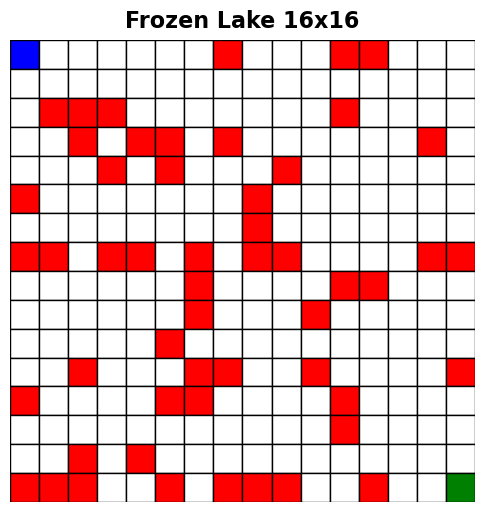

In [7]:
env = gym.make('FrozenLake-v1', desc=MAPS["16x16"], is_slippery=True).unwrapped
# Need to change the values based on number of rows and columns

rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            

plot_lake(env, policy=None, title = 'Frozen Lake 16x16')

In [8]:
def trainVI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", 'Discount', "Policy", "Iteration", 
                                  "Time", "Reward",
                                  "Value Function",'Avg_Steps','Steps_StDev','Success_Rate'
                                 ])
    vi_run_full = pd.DataFrame()

    for gamma in discount:
        for eps in epsilon:
            vi = ValueIteration(P, R, gamma=gamma, epsilon=eps, max_iter=int(1e15))
            vi_run, vi_policy = vi.run()
            vi_run_df = pd.DataFrame(vi_run)
            vi_run_df['Eps'] = str(float(eps))
            vi_run_df['Gamma'] = str(float(gamma))

            reward = max(vi_run_df['Reward'])
            steps, steps_stddev, failures = get_score(env, vi.policy, None)
            info = [float(eps),float(gamma), vi.policy, vi.iter, vi.time, reward,
                    vi.V, steps,steps_stddev,
                    # Success is 100% - failure%
                    100-failures]
            df_length = len(vi_df)
            vi_df.loc[df_length] = info
                    
            vi_run_full = pd.concat([vi_run_full,vi_run_df])
            
    return vi_df, vi_policy, vi_run,vi,vi_run_full

In [9]:
%%time
discount= [0.5,0.75,0.9,0.99]
epsilon=[1e-3,1e-5,1e-7]

vi_df,vi_policy,vi_run,vi,vi_run_full = trainVI(T, R, discount= discount, epsilon=epsilon)
df = pd.DataFrame(vi_run)
vi_df

Wall time: 1min 56s


,Epsilon,Discount,Policy,Iteration,Time,Reward,Value Function,Avg_Steps,Steps_StDev,Success_Rate
0,1.000000e-03,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, ...",8,0.003506,0.418572,"(-0.019921874999999995, -0.019921874999999995,...",1554.781013,1143.259756,79.0
1,1.000000e-05,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",14,0.004999,0.418724,"(-0.019998779699610104, -0.01999878090628411, ...",2791.229282,2264.183026,72.4
2,1.000000e-07,0.50,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",21,0.006778,0.418725,"(-0.01999999132446202, -0.019999992630665365, ...",2851.080688,2323.927896,75.6
3,1.000000e-03,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",19,0.006055,0.531360,"(-0.03983115985829498, -0.039831368975283096, ...",2595.538265,2001.784933,78.4
4,1.000000e-05,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",34,0.011038,0.531431,"(-0.03999822032868225, -0.039998463022299924, ...",2788.221333,2199.172801,75.0
5,1.000000e-07,0.75,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",48,0.017159,0.531431,"(-0.04000044526607615, -0.0400006880877755, -0...",2784.148248,2156.518415,74.2
6,1.000000e-03,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",51,0.014292,0.680851,"(-0.09956120718806903, -0.09956558704426607, -...",2027.660079,1769.686309,75.9
7,1.000000e-05,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",89,0.030016,0.680860,"(-0.10001776946324129, -0.1000221434591727, -0...",2095.043302,1941.201074,73.9
8,1.000000e-07,0.90,"(1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",132,0.042354,0.680860,"(-0.1000261437223723, -0.10003051612015848, -0...",2200.390438,1942.808231,75.3
9,1.000000e-03,0.99,"(1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, ...",412,0.133849,0.896248,"(-0.820252214260706, -0.8139047288099769, -0.8...",220.100503,93.560342,59.7


In [25]:
vi_run_full

,State,Action,Reward,Error,Time,Max V,Mean V,Iteration,Eps,Gamma
0,None,None,0.326667,1.326667e+00,0.000000,0.326667,-0.047799,1,0.001,0.5
1,None,None,0.379444,2.222222e-01,0.000991,0.379444,-0.056432,2,0.001,0.5
2,None,None,0.406111,5.666667e-02,0.000991,0.406111,-0.060137,3,0.001,0.5
3,None,None,0.413349,2.620370e-02,0.000991,0.413349,-0.061525,4,0.001,0.5
4,None,None,0.416746,1.013374e-02,0.001981,0.416746,-0.062176,5,0.001,0.5
...,...,...,...,...,...,...,...,...,...,...
863,None,None,0.896224,1.079092e-09,0.300332,0.896224,-0.434921,864,1e-07,0.99
864,None,None,0.896224,1.057468e-09,0.300332,0.896224,-0.434921,865,1e-07,0.99
865,None,None,0.896224,1.036278e-09,0.300332,0.896224,-0.434921,866,1e-07,0.99
866,None,None,0.896224,1.015512e-09,0.300332,0.896224,-0.434921,867,1e-07,0.99


In [10]:
vi_score_df = pd.DataFrame()
vi_score_df_full = pd.DataFrame()
for i in range(0,5):
    print(i)
    vi_df,vi_policy,vi_run,vi,vi_run_full = trainVI(T, R, discount= discount, epsilon=epsilon)
    vi_score_df = vi_df[['Epsilon','Discount','Success_Rate']]
    vi_score_df = vi_score_df.rename(columns={'Success_Rate':'Success_Rate_'+str(i)})
    vi_score_df_full = pd.concat([vi_score_df_full,vi_score_df],axis=1)

In [18]:
vi_score_df_full = vi_score_df_full.loc[:,~vi_score_df_full.columns.duplicated()].copy()

In [19]:
vi_score_df_full['Success_Mean'] = vi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].mean(axis = 1)
vi_score_df_full['Success_StdDev'] = vi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].std(axis = 1)
vi_score_df_full['Success_Max'] = vi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].max(axis = 1)

In [20]:
vi_score_df_full

,Epsilon,Discount,Success_Rate_0,Success_Rate_1,Success_Rate_2,Success_Rate_3,Success_Rate_4,Success_Mean,Success_StdDev,Success_Max
0,1.000000e-03,0.50,75.1,74.7,77.2,77.1,79.1,76.64,1.782695,79.1
1,1.000000e-05,0.50,74.0,74.0,72.7,72.4,72.4,73.10,0.830662,74.0
2,1.000000e-07,0.50,75.7,76.4,74.5,77.2,74.8,75.72,1.116692,77.2
3,1.000000e-03,0.75,76.2,74.0,75.6,75.9,77.4,75.82,1.225561,77.4
4,1.000000e-05,0.75,75.8,75.2,76.8,76.4,75.9,76.02,0.609918,76.8
5,1.000000e-07,0.75,77.8,75.5,78.2,74.5,75.7,76.34,1.588395,78.2
6,1.000000e-03,0.90,77.6,72.8,72.9,75.7,75.1,74.82,2.021633,77.6
7,1.000000e-05,0.90,74.7,76.8,74.2,77.4,76.2,75.86,1.366748,77.4
8,1.000000e-07,0.90,76.3,76.1,72.3,73.6,75.5,74.76,1.740115,76.3
9,1.000000e-03,0.99,57.7,56.8,59.5,56.0,57.5,57.50,1.301922,59.5


In [21]:
a1 = vi_score_df_full[vi_score_df_full['Epsilon']==1.e-07]
a2 = vi_score_df_full[vi_score_df_full['Epsilon']==1.e-05]
a3 = vi_score_df_full[vi_score_df_full['Epsilon']==1.e-03]

,Epsilon,Discount,Success_Rate_0,Success_Rate_1,Success_Rate_2,Success_Rate_3,Success_Rate_4,Success_Mean,Success_StdDev,Success_Max
2,1.000000e-07,0.50,75.7,76.4,74.5,77.2,74.8,75.72,1.116692,77.2
5,1.000000e-07,0.75,77.8,75.5,78.2,74.5,75.7,76.34,1.588395,78.2
8,1.000000e-07,0.90,76.3,76.1,72.3,73.6,75.5,74.76,1.740115,76.3
11,1.000000e-07,0.99,56.7,61.1,57.2,57.1,57.9,58.00,1.786057,61.1


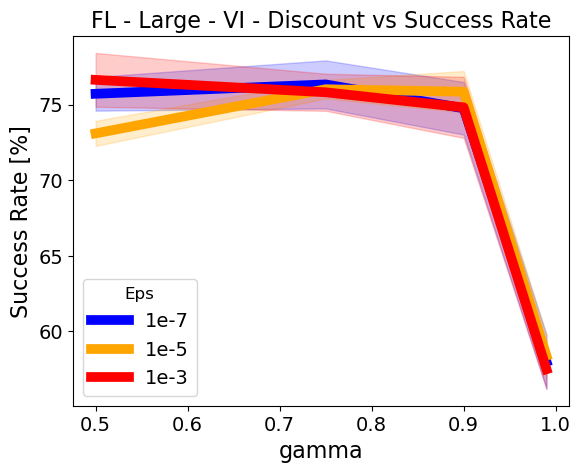

In [23]:
plt.plot(a1['Discount'],a1['Success_Mean'],linewidth =7,color="blue", label='1e-7')
plt.fill_between(a1['Discount'], a1['Success_Mean']+a1['Success_StdDev'],a1['Success_Mean']-a1['Success_StdDev'], alpha=0.2, color="blue")


plt.plot(a2['Discount'],a2['Success_Mean'],linewidth =7,color="orange", label='1e-5')
plt.fill_between(a2['Discount'], a2['Success_Mean']+a2['Success_StdDev'],a2['Success_Mean']-a2['Success_StdDev'], alpha=0.2, color="orange")

plt.plot(a3['Discount'],a3['Success_Mean'],linewidth =7,color="red", label='1e-3')
plt.fill_between(a3['Discount'], a3['Success_Mean']+a3['Success_StdDev'],a3['Success_Mean']-a3['Success_StdDev'], alpha=0.2, color="red")


plt.xlabel('gamma',fontsize = 16)
plt.ylabel('Success Rate [%]',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FL - Large - VI - Discount vs Success Rate', fontsize=16)
# plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Eps",title_fontsize=12, loc="best",prop={'size': 14})

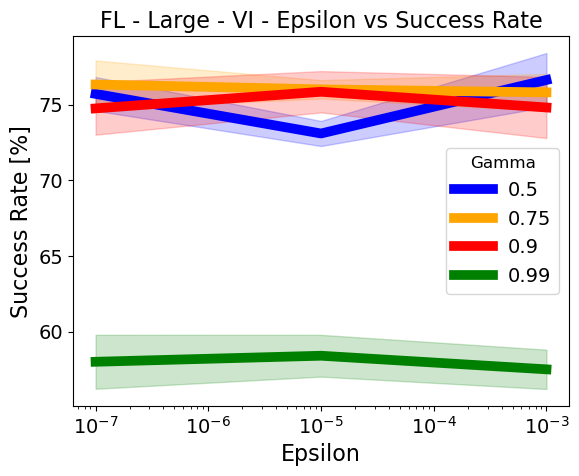

In [24]:
b1 = vi_score_df_full[vi_score_df_full['Discount']==0.5]
b2 = vi_score_df_full[vi_score_df_full['Discount']==0.75]
b3 = vi_score_df_full[vi_score_df_full['Discount']==0.9]
b4 = vi_score_df_full[vi_score_df_full['Discount']==0.99]


plt.plot(b1['Epsilon'],b1['Success_Mean'],linewidth =7,color="blue", label='0.5')
plt.fill_between(b1['Epsilon'], b1['Success_Mean']+b1['Success_StdDev'],b1['Success_Mean']-b1['Success_StdDev'], alpha=0.2, color="blue")


plt.plot(b2['Epsilon'],b2['Success_Mean'],linewidth =7,color="orange", label='0.75')
plt.fill_between(b2['Epsilon'], b2['Success_Mean']+b2['Success_StdDev'],b2['Success_Mean']-b2['Success_StdDev'], alpha=0.2, color="orange")

plt.plot(b3['Epsilon'],b3['Success_Mean'],linewidth =7,color="red", label='0.9')
plt.fill_between(b3['Epsilon'], b3['Success_Mean']+b3['Success_StdDev'],b3['Success_Mean']-b3['Success_StdDev'], alpha=0.2, color="red")

plt.plot(b4['Epsilon'],b4['Success_Mean'],linewidth =7,color="green", label='0.99')
plt.fill_between(b4['Epsilon'], b4['Success_Mean']+b4['Success_StdDev'],b4['Success_Mean']-b4['Success_StdDev'], alpha=0.2, color="green")


plt.xlabel('Epsilon',fontsize = 16)
plt.ylabel('Success Rate [%]',fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.ylim(75,85)
plt.title('FL - Large - VI - Epsilon vs Success Rate', fontsize=16)
plt.legend(title="Gamma",title_fontsize=12, loc="best",prop={'size': 14})

In [26]:
vi_df_05_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.5']))]

vi_df_075_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.75']))]

vi_df_09_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.9']))]

vi_df_099_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.99']))]

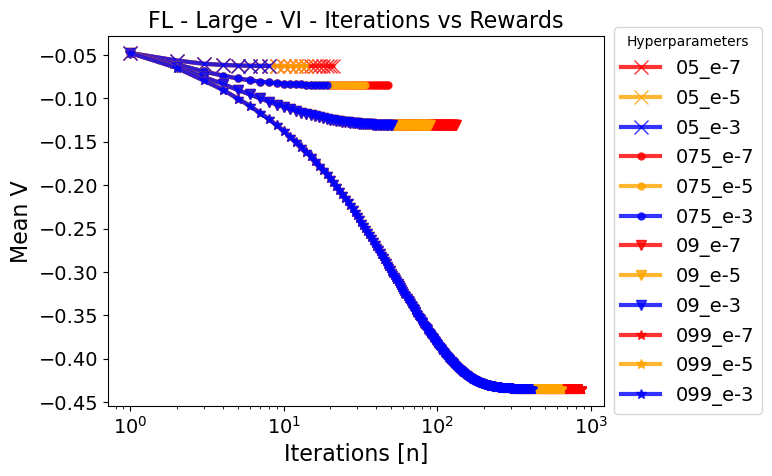

In [32]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5')
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3')

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7')
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5')
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3')

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='09_e-7')
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5')
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='09_e-3')

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='099_e-7')
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5')
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='099_e-3')


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FL - Large - VI - Iterations vs Rewards', size =16)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.xscale('log')

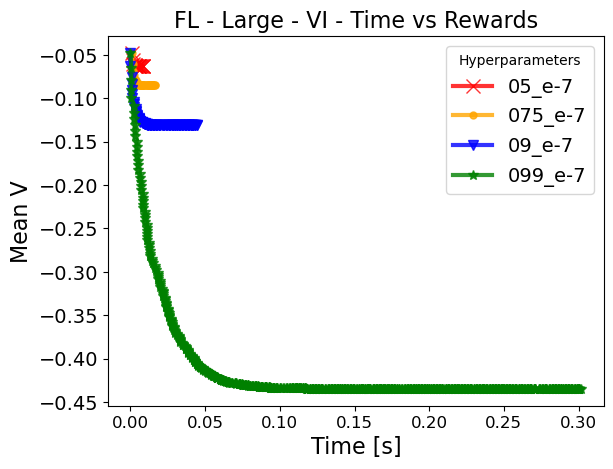

In [41]:
plt.plot(vi_df_05_e7['Time'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
#plt.plot(vi_df_05_e5['Time'],vi_df_05_e5['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'firebrick', label='05_e-5')
#plt.plot(vi_df_05_e3['Time'],vi_df_05_e3['Reward'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'lightcoral', label='05_e-3')

plt.plot(vi_df_075_e7['Time'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
#plt.plot(vi_df_075_e5['Time'],vi_df_075_e5['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'bisque', label='075_e-5')
#plt.plot(vi_df_075_e3['Time'],vi_df_075_e3['Reward'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'peru', label='075_e-3')

plt.plot(vi_df_09_e7['Time'],vi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
#plt.plot(vi_df_09_e5['Time'],vi_df_09_e5['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'navy', label='09_e-5')
#plt.plot(vi_df_09_e3['Time'],vi_df_09_e3['Reward'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'cyan', label='09_e-3')

plt.plot(vi_df_099_e7['Time'],vi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')
#plt.plot(vi_df_099_e5['Time'],vi_df_099_e5['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lightgreen', label='099_e-5')
#plt.plot(vi_df_099_e3['Time'],vi_df_099_e3['Reward'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'lawngreen', label='099_e-3')


plt.xlabel("Time [s]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title('FL - Large - VI - Time vs Rewards', size =16)
#plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})
#plt.xscale('log')

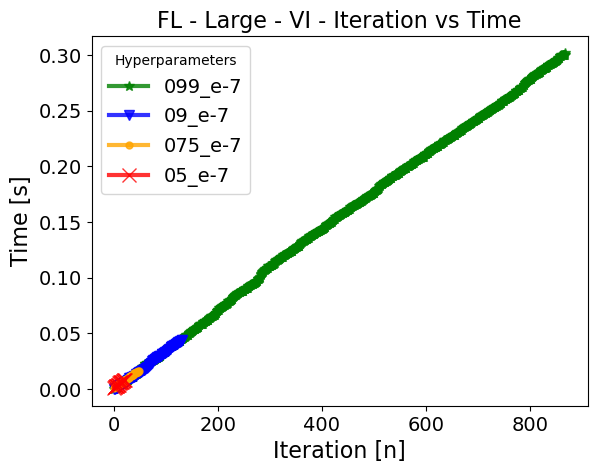

In [56]:
plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Time'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')
plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Time'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Time'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Time'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')

plt.xlabel("Iteration [n]",fontsize = 16)
plt.ylabel("Time [s]",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FL - Large - VI - Iteration vs Time', size =16)
#plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})

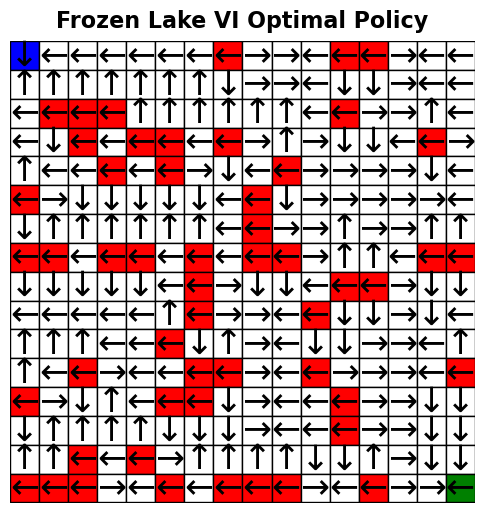

In [46]:
best_policy = np.array(list(vi_df.loc[0]["Policy"]))
best_policy = best_policy.reshape(rows, cols)
title='Frozen Lake VI Optimal Policy'
plot_lake(env, best_policy, title='Frozen Lake VI Optimal Policy')

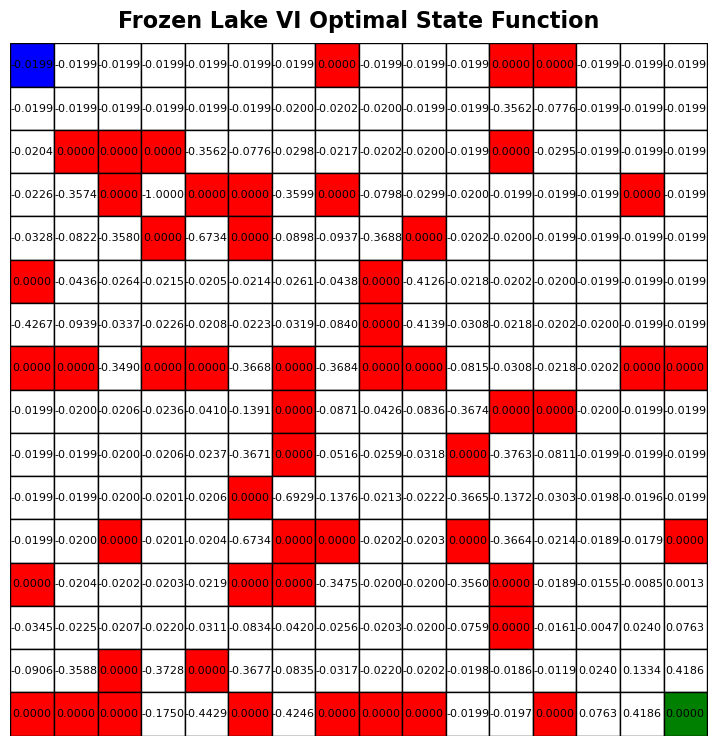

In [55]:
best_val_fn = np.array(list(vi_df.loc[0]["Value Function"]))
best_val_fn = best_val_fn.reshape(rows, cols)
plot_lake_values(env, best_val_fn, title='Frozen Lake VI Optimal State Function')